# NBL Canada 2017-2018 Player Stats

Let's take a look at player stats over the season—we'll pick a player and chart their numbers for all of the games they've played in 2017-2018.

We're using [Python 3](https://docs.python.org/3/) with a few dependencies:

- [`requests`](http://docs.python-requests.org/) is used to make HTTP requests
- [`bs4`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) (Beautiful Soup 4) is used to parse HTML

And first thing out of the gate we'll need to import those:

In [1]:
import requests
from bs4 import BeautifulSoup

And a few [standard library](https://docs.python.org/3/library/) dependencies:

In [2]:
import itertools

## Team Calendar

[The NBL Canada website](http://nblcanada.ca) has two formats for its calendar, one is a month view, the other is a day view. We'll use the month view here to lower the number of requests we need to make to get all of the games in the season (that is, one request for each month of the season instead of one for each day). The monthly calendar (shown below) shows each of the events on that day with a Box Score link.

![November 2017 NBLC Schedule](./nblcanada.ca_composite_y_2017_m_11.png)

The URL structure for the calendar has `year` and `month` query parameters:

    http://nblcanada.ca/composite?y=2017&m=11

Inspecting the page, the markup for a single event (a few attributes removed for brevity):

```html
<div class="cal-event">
    <div class="cal-sport">
        <a href="/sports/mbkb/2017-18/schedule">Men's Basketball</a>
    </div>
    <div class="teams">
        <div class="team-name">St. John's Edge</div>
        <div class="team-name"> <span class="va">at</span> Island Storm</div>
    </div>
    <div class="cal-status">Final</div>
    <a href="/sports/mbkb/2017-18/boxscores/20171118_by41.xml" class="cal-result">97 - 96</a>
    <div class="cal-links">
        <a href="/sports/mbkb/2017-18/boxscores/20171118_by41.xml" title="Box Score">BX</a>
    </div>
</div>
```

To get a list of all the events played this season we will iterate over all of the months, format a link to the calendar for that month, and append it to a running list of all the calendar links:

In [3]:
calendar_links = []
for month in range(11, 13):
    calendar_links.append(
        "http://nblcanada.ca/composite?y={year}&m={month:02d}".format(year = "2017", month = month))
for month in range( 1,  7):
    calendar_links.append(
        "http://nblcanada.ca/composite?y={year}&m={month:02d}".format(year = "2018", month = month))

Alright, now we have a list of all the calendars:

In [4]:
calendar_links

['http://nblcanada.ca/composite?y=2017&m=11',
 'http://nblcanada.ca/composite?y=2017&m=12',
 'http://nblcanada.ca/composite?y=2018&m=01',
 'http://nblcanada.ca/composite?y=2018&m=02',
 'http://nblcanada.ca/composite?y=2018&m=03',
 'http://nblcanada.ca/composite?y=2018&m=04',
 'http://nblcanada.ca/composite?y=2018&m=05',
 'http://nblcanada.ca/composite?y=2018&m=06']

Before we go any futher, let's pick a team:

In [5]:
team_name = "St. John's Edge"

Additionally, if you want to look at just $x$ games, we can set a `total_game_count` to that value (or `None` if we want to look at everything):

In [6]:
total_game_count = 45 # The St. John's Edge played 45 regular season games

Let's map each of those links to the HTML for the calendar and then to the list of all of the events on the calendar for our team:

In [7]:
events = []
for calendar_link in calendar_links:
    calendar_html = BeautifulSoup(requests.get(calendar_link).text, "html.parser")
    events.append(calendar_html.select(".cal-event"))
# Hand-wavy bit, we'll need to "flatten" the list
events = list(itertools.chain(*events))

In [8]:
our_events = []
for event in events:
    away_team, home_team = map(
        # The home team has a "at" prefix which adds whitespace, so we'll use .stripped_strings and have to
        # index into the list of children: ["at", "team name"]
        lambda e: e.string if e.string else list(e.stripped_strings)[1],
        event.select(".team-name"))
    if home_team == team_name or away_team == team_name:
        our_events.append(event)

With the list of all our events in hand (in `our_events`) we can pick out the "Box Score" link for each event and append them to a running list of all the box score links:

In [9]:
our_box_score_links = []
for event in our_events:
    box_score_links = event.select("a[title='Box Score']")
    if not box_score_links:
        # We've discovered a live or upcoming game
        continue
    box_score_link, = box_score_links
    our_box_score_links.append(box_score_link.attrs.get("href"))

The way the links work in the HTML, we have a relative path to the file, not the whole URL. Let's take a peek at the first link to get an idea of what we're working with:

In [10]:
our_box_score_links[0]

'/sports/mbkb/2017-18/boxscores/20171118_by41.xml'

We'll need to format the links to get a complete URL. Let's write a function to do that:

In [11]:
def format_box_score_link(link):
    return "http://nblcanada.ca" + link

Let's take a look at the complete list formatted:

In [12]:
for box_score_link in our_box_score_links:
    print(format_box_score_link(box_score_link))

http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171118_by41.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171119_ktrq.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171121_c5zt.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171122_28lb.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171124_j0ft.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171201_1j6s.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171202_mamv.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171201_1j6s.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171202_mamv.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171205_l26a.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171206_yxks.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171213_lto8.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171215_crx9.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscores/20171217_vlts.xml
http://nblcanada.ca/sports/mbkb/2017-18/boxscore

Alrighty, let's take a look at the box scores for our games. We will need to iterate over each of the links above and request the HTML for the page.

If you have a keen eye, you'll notice that there are duplicates in the list. That's due to overlap in, for example, the November calendar and the December calendar, where we'll have games showing up on both. Let's format the links **and deduplicate** while iterating. Here we're using [`dict.fromkeys`](https://docs.python.org/3/library/stdtypes.html#dict.fromkeys) to construct an ordered set (in the mathemtatical sense) of all the links:

In [13]:
box_scores = []
for box_score_link in map(format_box_score_link, dict.fromkeys(our_box_score_links).keys()):
    box_scores.append(requests.get(box_score_link).text)

## Box Scores

The Box Score page (example shown below) displays the stats for a game along with the game information. The table containing the player stats unfortunately doesn't contain percentages so will be doing a bit of text parsing once we get to that (spoliers!).

![Niagara River Lions at St. John's Edge Box Score](./nblcanada.ca_sports_mbkb_2017-18_boxscores_20180402_wffm.xml.png)

Inspecing the page, the table for the two teams are separate in the markup (thankfully!) and each have a `caption` with the team name:

```html
<table>
    <caption class="caption">
        <h2><span class="team-name">Niagara River Lions</span></h2>
    </caption>
    <thead>
        <tr>
            <th scope="col" class="col-head pinned-col text">Player</th>
            <th scope="col" class="col-head">MIN</th>
            <th scope="col" class="col-head">FGM-A</th>
            <th scope="col" class="col-head">3PM-A</th>
            <th scope="col" class="col-head">FTM-A</th>
            <th scope="col" class="col-head">OREB</th>
            <th scope="col" class="col-head">DREB</th>
            <th scope="col" class="col-head">REB</th>
            <th scope="col" class="col-head">AST</th>
            <th scope="col" class="col-head">STL</th>
            <th scope="col" class="col-head">BLK</th>
            <th scope="col" class="col-head">TO</th>
            <th scope="col" class="col-head">PF</th>
            <th scope="col" class="col-head">PTS</th>
        </tr>
    </thead>
    <tbody>
        <tr class="group-head">
            <th scope="rowgroup" class="row-head pinned-col text"><strong>STARTERS</strong></th>
            <td colspan="13">&nbsp;</td>
        </tr>
        <tr>
            <th scope="row" class="row-head pinned-col text">
                <span class="uniform">0 - </span>
                <a href="../players?id=3t3p5fmhkhk7qgu2" class="player-name">Jaylon Tate</a>
            </th>
            <td>34</td>
            <td>1-5</td>
            <td>0-1</td>
            <td>1-2</td>
            <td>0</td>
            <td>2</td>
            <td>2</td>
            <td>4</td>
            <td>0</td>
            <td>0</td>
            <td>0</td>
            <td>1</td>
            <td>3</td>
        </tr>
        <!-- And so on, repeated for each starter -->
    </tbody>
    <tbody>
        <tr class="group-head">
            <th scope="rowgroup" class="row-head pinned-col text"><strong>RESERVES</strong></th>
            <td colspan="13">&nbsp;</td>
        </tr>
        <tr>
            <th scope="row" class="row-head pinned-col text">
                <span class="uniform">2 - </span>
                <a href="../players?id=gt2kpg91kerqhajg" class="player-name">Joe Rocca</a>
            </th>
            <td>3</td>
            <td> 0-1
            </td>
            <td> 0-1
            </td>
            <td> 0-0
            </td>
            <td>1</td>
            <td>1</td>
            <td>2</td>
            <td>0</td>
            <td>0</td>
            <td>0</td>
            <td>0</td>
            <td>1</td>
            <td> 0
            </td>
        </tr>
        <!-- And so on, repeated for each reserve -->
    </tbody>
    <tbody>
        <tr class="totals">
            <th scope="rowgroup" class="row-head pinned-col text">TOTALS</th>
            <td>&nbsp;</td>
            <td> 35-83
            </td>
            <td> 8-29
            </td>
            <td> 21-29
            </td>
            <td>11</td>
            <td>31</td>
            <td>42</td>
            <td>14</td>
            <td>6</td>
            <td>6</td>
            <td>6</td>
            <td>22</td>
            <td> 99
            </td>
        </tr>
        <tr class="totals">
            <td class="pinned-col">&nbsp;</td>
            <td>&nbsp;</td>
            <td> 42.2%
            </td>
            <td> 27.6%
            </td>
            <td> 72.4%
            </td>
            <td colspan="9">&nbsp;</td>
        </tr>
    </tbody>
</table>
```

To get our bearings, let's take a look at the first game we've played before trying to parse *all* of the games at once. (It might help to open up the box score for the first game in your browser to double-check the results.)

In [14]:
first_box_score = box_scores[0]

As both teams have their stats on the same page, we will only need to look at the first table (the outer [`next`](https://docs.python.org/3/library/functions.html#next) call) that has the correct team name (the outer [`filter`](https://docs.python.org/3/library/functions.html#filter) call):

In [15]:
first_game_table = next(filter(
    # The first table caption with the correct team name is the element we want
    lambda table: next(iter(table.select("caption > h2 > .team-name"))).string == team_name,
    BeautifulSoup(first_box_score, "html.parser").select("div.stats-box table")))

## Parsing Box Scores

With our hands on the first game table, we need to parse out the HTML (shown above) into something useful. The goal of this whole exercise is to be able to look at stats for individual players, so let's construct a list of dictionaries with player names as keys and their stats as values.

The following two functions parse the table HTML into the desired structure:

In [16]:
def cols_from_row(row):
    """Returns a list of column values in the given row."""
    cols = row.find_all("th") + row.find_all("td")
    cols = [' '.join(list(ele.stripped_strings)) for ele in cols]
    return cols

def stats_from_table(table):
    """Returns a dictionary with player names as keys and their stats as values."""
    stats = {}
    rows = table.find_all("tr")
    heading_row, *body_rows = rows
    headings = cols_from_row(heading_row)
    heading_count = len(headings)
    for row in body_rows:
        cols = cols_from_row(row)
        if not len(cols) == heading_count:
            continue
        player, minutes, *rest = cols
        if not minutes:
            # The team totals doesn't have minutes
            # And though this isn't an individual stat, we'll hold on to these numbers
            stats["TEAM"] = dict(zip(headings[2:], rest))
            continue
        player_stats = dict(zip(headings, cols))
        # We don't need the player name in their stats too
        player_stats.pop("Player")
        stats[player] = player_stats
    return stats

Uncomment this to see how the stats are structured:

In [17]:
# stats_from_table(first_game_table)

Having that working, we can iterate over all of the box scores and accumulate them into a single list of stats:

Note: we're using `total_game_count` here (defined above) to limit the number of games if necessary.

In [18]:
all_game_stats = []
for box_score in box_scores[:total_game_count]:
    markup = BeautifulSoup(box_score, "html.parser")
    game_title, game_date = list(
        markup.select(".game-boxscore h1:nth-of-type(1)")[0].stripped_strings)
    stats = stats_from_table(next(filter(
        lambda table: next(iter(table.select("caption > h2 > .team-name"))).string == team_name,
        markup.select("div.stats-box table"))))
    all_game_stats.append({
        "game_date": game_date,
        "game_title": game_title,
        "stats": stats,
    })

Uncomment this to peek inside the structure:

In [19]:
# all_game_stats

## Individual Player Stats

Everything leading up to this section was getting our hands on the data in a usable form. Now for the fun bit:

1. Pick a player (note the format)
2. Turn just their data into a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)
3. Compute additional stats that the NBL doesn't have on their site
4. Plot stuff

(If you're new to Pandas I'd recommend reading through [10 Minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html).)

In [20]:
player = "3 - Alex Johnson"

In [21]:
import pandas
import seaborn

In [22]:
data = pandas.DataFrame(list(map(
    lambda game_stats: game_stats["stats"].get(player),
    filter(
        lambda game_stats: player in game_stats["stats"],
        all_game_stats))),
    columns=["MIN", "FGM-A", "3PM-A", "PTS"])
data["Game"] = data.apply(lambda r: r.name + 1, axis=1)
data["FGM"] = data.apply(lambda r: int(r["FGM-A"].split("-")[0]), axis=1)
data["FGA"] = data.apply(lambda r: int(r["FGM-A"].split("-")[1]), axis=1)
data["FG%"] = data.apply(lambda r: r["FGM"] / r["FGA"] if r["FGA"] != 0 else None, axis=1)
data["3PM"] = data.apply(lambda r: int(r["3PM-A"].split("-")[0]), axis=1)
data["3PA"] = data.apply(lambda r: int(r["3PM-A"].split("-")[1]), axis=1)
data["3P%"] = data.apply(lambda r: r["3PM"] / r["3PA"] if r["3PA"] != 0 else None, axis=1)
data = data.drop(columns=["FGM-A", "3PM-A"])

In [23]:
data
# Use data.to_csv() for quick export

,MIN,PTS,Game,FGM,FGA,FG%,3PM,3PA,3P%
0,30,10,1,3,8,0.375000,2,4,0.500000
1,36,17,2,7,13,0.538462,3,6,0.500000
2,32,11,3,1,7,0.142857,1,5,0.200000
3,34,19,4,8,15,0.533333,2,5,0.400000
4,30,13,5,3,9,0.333333,3,4,0.750000
5,25,7,6,3,7,0.428571,0,2,0.000000
6,28,2,7,1,4,0.250000,0,2,0.000000
7,26,13,8,5,9,0.555556,2,5,0.400000
8,27,11,9,5,7,0.714286,1,1,1.000000
9,37,11,10,4,7,0.571429,1,3,0.333333


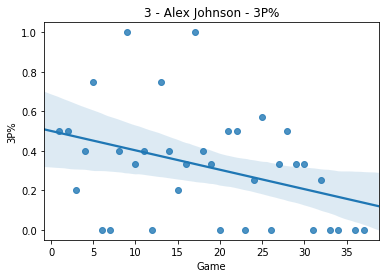

In [24]:
stat = "3P%"
plot = seaborn.regplot("Game", stat, data=data)
plot.set_title("{} - {}".format(player, stat))
plot.set_ylim(-0.05, 1.05)
None

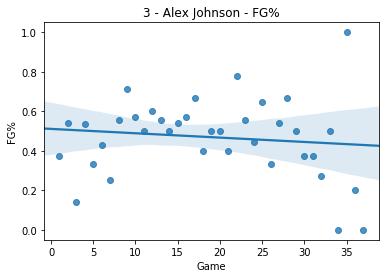

In [25]:
stat = "FG%"
plot = seaborn.regplot("Game", stat, data=data)
plot.set_title("{} - {}".format(player, stat))
plot.set_ylim(-0.05, 1.05)
None